Episode: 0, Reward: -5, Success: False
Episode: 1, Reward: -5, Success: False
Episode: 2, Reward: -5, Success: False
Episode: 3, Reward: -5, Success: False
Episode: 4, Reward: -5, Success: False
Episode: 5, Reward: -5, Success: False
Episode: 6, Reward: -5, Success: False
Episode: 7, Reward: -5, Success: False
Episode: 8, Reward: -5, Success: False
Episode: 9, Reward: -5, Success: False
Episode: 10, Reward: -5, Success: False
Episode: 11, Reward: -5, Success: False
Episode: 12, Reward: -5, Success: False
Episode: 13, Reward: -5, Success: False
Episode: 14, Reward: -5, Success: False
Episode: 15, Reward: -5, Success: False
Episode: 16, Reward: -5, Success: False
Episode: 17, Reward: -5, Success: False
Episode: 18, Reward: -5, Success: False
Episode: 19, Reward: -5, Success: False
Episode: 20, Reward: -5, Success: False
Episode: 21, Reward: -5, Success: False
Episode: 22, Reward: -5, Success: False
Episode: 23, Reward: -5, Success: False
Episode: 24, Reward: -5, Success: False
Episode: 2

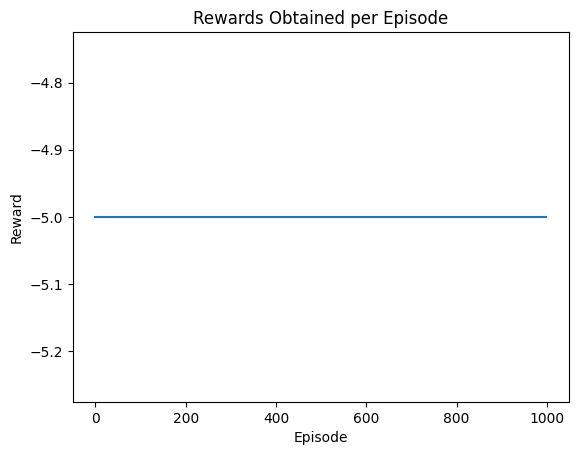

Success rate: 0.00%


In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import gym
from gym.envs.registration import register
import random
from collections import deque
import matplotlib.pyplot as plt

# Register the custom FrozenLake environment
register(
    id='CustomRewardFrozenLake-v1',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name': '4x4', 'is_slippery': False},
    max_episode_steps=100,
    reward_threshold=0.78,  # Adjust the reward threshold if needed
)

# Define the custom FrozenLake environment with modified rewards
class CustomRewardFrozenLake(gym.Env):
    def __init__(self):
        self.env = gym.make("CustomRewardFrozenLake-v1")
        self.observation_space = self.env.observation_space
        self.action_space = self.env.action_space

    def step(self, action):
        state, reward, done, info = self.env.step(action)
        if reward == 0 and not done:
            reward = 0
        elif reward == 0 and done:
            reward = -5
        elif reward == 1:
            reward = 1
        return state, reward, done, info

    def reset(self):
        return self.env.reset()

    def render(self):
        self.env.render()

    def close(self):
        self.env.close()

# Define Actor Network
class Actor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

# Define Critic Network
class Critic(nn.Module):
    def __init__(self, input_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define Experience Buffer
class ExperienceBuffer:
    def __init__(self, buffer_size):
        self.buffer = deque(maxlen=buffer_size)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return states, actions, rewards, next_states, dones

# Discounted rewards function
def discount_rewards(rewards, gamma=0.99):
    discounted_rewards = []
    running_add = 0
    for r in reversed(rewards):
        running_add = running_add * gamma + r
        discounted_rewards.insert(0, running_add)
    return discounted_rewards

# Function to compute advantages
def compute_advantages(critic, states, rewards):
    values = critic(states)
    advantages = rewards - values
    return advantages

# Initialize the environment
env = CustomRewardFrozenLake()
# env = gym.make('FrozenLake-v1')
input_dim = env.observation_space.n
output_dim = env.action_space.n

# Initialize the actor and critic networks
actor = Actor(input_dim, output_dim)
critic = Critic(input_dim)

# Initialize the optimizers
optimizer_actor = optim.Adam(actor.parameters(), lr=0.01)
optimizer_critic = optim.Adam(critic.parameters(), lr=0.01)

# Initialize the experience buffer
buffer_size = 10000
experience_buffer = ExperienceBuffer(buffer_size)

# Training loop
num_episodes = 1000
success_count = 0

# Store rewards obtained per episode
episode_rewards = []

# Inside the training loop
for episode in range(num_episodes):
    state = env.reset()
    episode_reward = 0
    success = False

    states = []
    actions = []
    rewards = []

    while True:
        # Select action
        state_one_hot = torch.zeros(1, input_dim)
        state_one_hot[0, state] = 1
        states.append(state_one_hot)

        action_probs = actor(state_one_hot)
        action = torch.multinomial(action_probs, num_samples=1).item()
        actions.append(action)

        # Take action
        next_state, reward, done, _ = env.step(action)
        rewards.append(reward)
        episode_reward += reward

        # Store experience in buffer
        experience_buffer.add(state, action, reward, next_state, done)

        # Update state
        state = next_state

        if done:
            success = reward == 1
            if success:
                success_count += 1
            break

    # Compute discounted rewards
    discounted_rewards = torch.tensor(discount_rewards(rewards), dtype=torch.float32)

    # Compute advantages
    states_tensor = torch.stack(states)
    advantages = compute_advantages(critic, states_tensor, discounted_rewards)

    # Compute actor loss
    log_probs = torch.log(actor(states_tensor))
    log_probs_flat = log_probs.view(-1, output_dim)
    batch_size = log_probs_flat.shape[0]
    idx = torch.arange(batch_size) * output_dim + torch.tensor(actions)
    log_probs_selected = log_probs_flat.view(-1)[idx]
    actor_loss = -(log_probs_selected * advantages).mean()

    # Compute critic loss
    critic_loss = ((critic(states_tensor).squeeze() - discounted_rewards) ** 2).mean()

    # Update actor and critic
    optimizer_actor.zero_grad()
    optimizer_critic.zero_grad()
    actor_loss.backward()
    critic_loss.backward()
    optimizer_actor.step()
    optimizer_critic.step()

    # Store episode reward
    episode_rewards.append(episode_reward)

    print("Episode: {}, Reward: {}, Success: {}".format(episode, episode_reward, success))

# Plotting rewards obtained per episode
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards Obtained per Episode')
plt.show()

print("Success rate: {:.2f}%".format(success_count / num_episodes * 100))
env.close()
